### Preliminaries

In [1]:
import pyprob
import numpy as np
import ot
import torch
import cProfile
import pickle
import logging
from io import StringIO
from contextlib import redirect_stdout
import sys, os


from showerSim import invMass_ginkgo
from showerSim.utils import get_logger
from torch.utils.data import DataLoader
from pyprob.nn.dataset import OnlineDataset
from pyprob.util import InferenceEngine
from pyprob.util import to_tensor
from pyprob import Model
import math
from pyprob.distributions import Normal

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as mpl_cm
plt.ion()

from sbi import utils
from sbi import analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn


import sklearn as skl
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from joblib import Parallel, delayed
from torch.nn.functional import pad

#To silence print logging from within Ginkgo simulator.
class NullIO(StringIO):
    def write(self, txt):
        pass

def silent(fn):
    """Decorator to silence functions."""
    def silent_fn(*args, **kwargs):
        with redirect_stdout(NullIO()):
            return fn(*args, **kwargs)
    return silent_fn

class BlockPrinting:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


logger = get_logger()
logger.setLevel(logging.CRITICAL)

# Ginkgo SBI Examples

This notebook contains some baseline examples for performing inference for the rate parameters of Ginkgo using the SBI package. We've been using the version of ginkgo written for pyprob, but this notebook doesn't use any pyprob-specific features, and it is likely the pyro version could be easily substituted.  Here we define the simulator and uniform priors for each parameter.

In [2]:
QCD_mass = 30.
jetdir = np.array([1.,1.,1.])
jetP = 400.
jetvec = jetP * jetdir / np.linalg.norm(jetdir) 


# Actual parameters
pt_min = 0.3**2
M2start = torch.tensor(QCD_mass**2)
jetM = np.sqrt(M2start) ## Mass of initial jet
jet4vec = np.concatenate((np.sqrt(jetP**2 + jetM**2).reshape(-1), jetvec))
minLeaves = 1
maxLeaves = 10000 # unachievable, to prevent rejections
maxNTry = 100


ginkgo_simulator = invMass_ginkgo.SimulatorModel(jet_p=jet4vec,  # parent particle 4-vector
                                    pt_cut=float(pt_min),  # minimum pT for resulting jet
                                    Delta_0= M2start,  # parent particle mass squared -> needs tensor
                                    M_hard=jetM,  # parent particle mass
                                    minLeaves=1,  # minimum number of jet constituents
                                    maxLeaves=10000,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
                                    suppress_output=True)

In [3]:
prior_min = [1e-3,1e-3]
prior_max = [30.,30.]
prior_full = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

## Summaries
We consider the full data to be the leaves. The first summary involves sorting the leaves according to energy and then flattening and padding to length 200. If the flattened data is greater than length 200, then we truncate. In most cases, we're unlikely to be truncating so we retain a lot of data - we can check this quickly:

In [4]:
# Test how often we truncate.
with BlockPrinting():
    count = 0 # Represents number of times we truncate
    truncated_rates = [] # Will contain the parameters for simulations which require truncation.
    for _ in range(2000):
        sample = prior_full.sample()
        if (len(ginkgo_simulator(sample)['leaves']))>50:
            count+=1
            truncated_rates.append(sample)

truncated_rates=torch.stack(truncated_rates)

/home/sragy/DISPyprob/ToyJetsShower/showerSim/invMass_ginkgo.py:297: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")
/home/sragy/DISPyprob/ToyJetsShower/showerSim/invMass_ginkgo.py:296: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pL inv mass from p^2 in lab  frame: {np.sqrt(pL_mu[0]**2-np.linalg.norm(pL_mu[1::])**2)}")


In [5]:
print(f"percentage of leaves truncated: {count/2000*100}%")
print(f'root_rate: min = {truncated_rates[:,0].min()}, max = {truncated_rates[:,0].max()}, mean {truncated_rates[:,0].mean()}')
print(f'decay_rate: min = {truncated_rates[:,1].min()}, max = {truncated_rates[:,1].max()}, mean {truncated_rates[:,1].mean()}')

percentage of leaves truncated: 0.95%
root_rate: min = 0.06819604337215424, max = 17.068885803222656, mean 5.55795955657959
decay_rate: min = 0.05471391603350639, max = 1.7203549146652222, mean 0.6872897148132324


We can see from the above, that <2% of samples are truncated. Recording the parameters that lead to truncated outputs, we find that a small decay rate substantially increases the chances of truncation occuring. Notice that the prior is uniform on [0.001, 30] for each parameter, which contrasts substantially with the range observed above for the decay rate.

In [6]:
# Summary where we sort, flatten and truncate.

def full_flat(leaves):
    
    # Sort and flatten
    flattened = np.ndarray.flatten(leaves[leaves[:, 0].argsort()]
)
    
    length = len(flattened)

    # Pad/Truncate
    if length >= 200:
        return flattened[:200]
    else:
        pad_length = 200 - length
        return np.pad(flattened,(0,pad_length))

We also define a second set of summaries as the first four moments of the energy of the leaves. 

In [7]:
def e_summaries(leaves):
    num_leaves = len(leaves)
    energies = leaves[:,0]
    e_mean = energies.mean() # total energy / num leaves
    e_std = energies.std()
    
    def nthmoment(n):
        return np.sum((energies - e_mean)**n/((num_leaves -1)*e_std**n))

    e_skewness = nthmoment(3)
    e_kurtosis = nthmoment(4)

    return torch.tensor([e_mean, e_std, e_skewness, e_kurtosis])

### Simulator wrapper and observations
For easy compatibility with sbi package, we define the below function which wraps the simulator and summary function. 

In [8]:
def get_simulator(summary_fn):
    
    @silent
    def simulator(params):
        leaves = ginkgo_simulator(params)['leaves']
        return summary_fn(leaves)

    return simulator

In [9]:
flat_sim = get_simulator(full_flat)
e_sim = get_simulator(e_summaries)

We also define a simple class to capture observations and summaries.

In [10]:
class GinkObs:
    def __init__(self, params):
        self.params = to_tensor(params)
        self.leaves = ginkgo_simulator(params)['leaves']
        self.flat_sum = full_flat(self.leaves)
        self.e_sum = e_summaries(self.leaves)

We produce an observation for each of the following inputs $[3,2], [15,2], [25,2], [25,25]$.

In [11]:
R3L2 = GinkObs([3,2])
R15L2 = GinkObs([15,2])
R25L2 = GinkObs([25,2])
R25L25 = GinkObs([25,25])

## Single round inference (amortised)

We produce the inferred posteriors and plot samples from them given the observations defined earlier. We use the APT (https://arxiv.org/pdf/1905.07488.pdf) method.

In [12]:
flat_posterior = infer(flat_sim, prior_full, method='APT', num_simulations=5000, num_workers=7)

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

/home/sragy/DISPyprob/ToyJetsShower/showerSim/invMass_ginkgo.py:297: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")
/home/sragy/DISPyprob/ToyJetsShower/showerSim/invMass_ginkgo.py:297: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")
/home/sragy/DISPyprob/ToyJetsShower/showerSim/invMass_ginkgo.py:297: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")
/home/sragy/DISPyprob/ToyJetsShower/showerSim/invMass_ginkgo.py:296: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pL inv mass from p^2 in lab  frame: {np.sqrt(pL_mu[0]**2-np.linalg.norm(pL_mu[1::])**2)}")
/home/sragy/DISPyprob/ToyJetsShower/showerSim/invMass_ginkgo.py:297: Runti

 Neural network successfully converged after 39 epochs.

In [13]:
e_posterior = infer(e_sim, prior_full, method='APT', num_simulations=5000, num_workers=7)

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 66 epochs.

In [14]:
# Plot helper

def pair_plt(posterior, obs):
    if posterior == e_posterior:
        x = obs.e_sum
    elif posterior == flat_posterior:
        x = obs.flat_sum

    samples = posterior.sample((10000,),x=x)
    fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=obs.params,
                        points_offdiag={'markersize': 6},
                        points_colors='r',
                        labels = ['root_rate', 'decay_rate']); 
    plt.show()

Below, we produce plots of the inferred posteriors for the four different observed datasets, for both different choices of summary. The red lines indicate the true parameters. We start with the flattened leaves. 

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

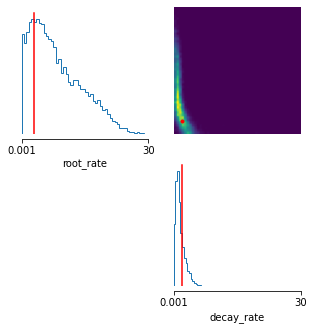

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

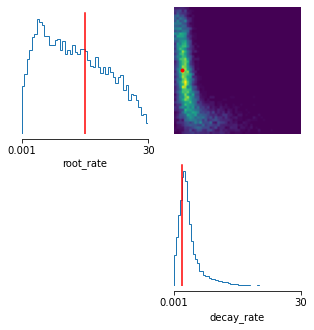

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

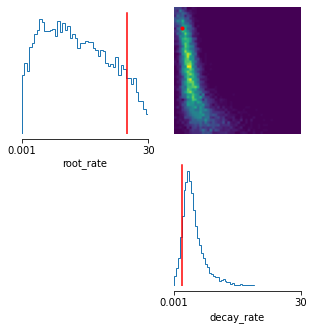

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

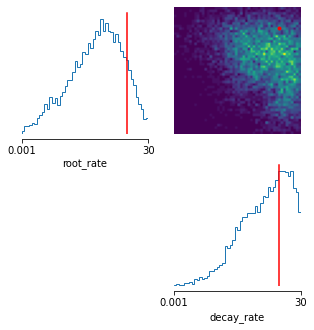

In [15]:
pair_plt(flat_posterior, R3L2)
pair_plt(flat_posterior, R15L2)
pair_plt(flat_posterior, R25L2)
pair_plt(flat_posterior, R25L25)

Plotting the inference using energy summaries:

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

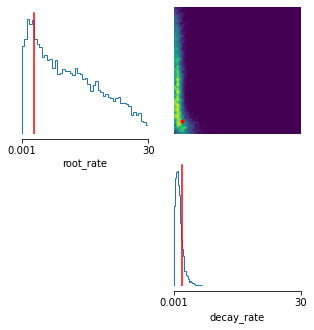

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

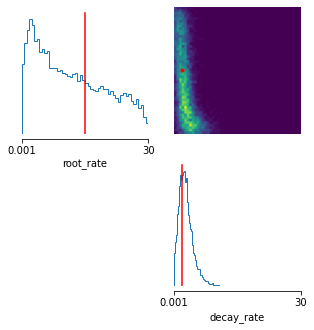

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

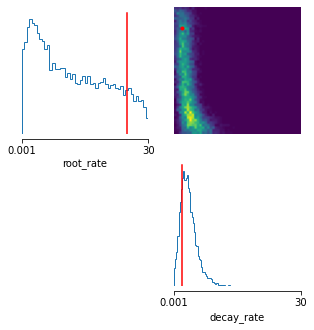

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

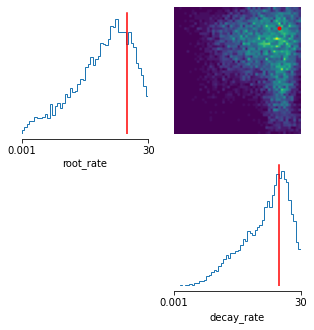

In [16]:
pair_plt(e_posterior, R3L2)
pair_plt(e_posterior, R15L2)
pair_plt(e_posterior, R25L2)
pair_plt(e_posterior, R25L25)

## Note:

APT is a sequential neural posterior estimation method, and it should be possible to run multiple rounds of the algorithm to improve inference. However, this does not appear to help in this case (for reasons unknown), and I have not included any multi-round inference attempts in this notebook.